In [2]:
import numpy as np
import os
import tensorflow as tf
import urllib2
import sys
import matplotlib.pyplot as plt
import cervix

sys.path.append('/home/jt2/Workspace/models/slim')
from datasets import dataset_utils
from nets import inception
from preprocessing import inception_preprocessing
import image_processing
%matplotlib inline

In [3]:
url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

# dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [ ]:
slim = tf.contrib.slim
image_size = inception.inception_v1.default_image_size

In [13]:
from preprocessing import inception_preprocessing
import tensorflow as tf

slim = tf.contrib.slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False, shuffle=True):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8, shuffle=shuffle)
    image_raw, label = data_provider.get(['image', 'label'])

    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [4]:
FLAGS = tf.app.flags.FLAGS
FLAGS.data_dir = '/home/jt2/Workspace/cervix/train'
FLAGS.train_dir= '/home/jt2/Workspace/cervix/train'
FLAGS.batch_size = 32
FLAGS.num_readers = 4
FLAGS.num_preprocess_threads = 4
FLAGS.input_queue_memory_factor = 1
FLAGS.image_size = 224

In [5]:
cervix_data_dir = '/home/jt2/Workspace/cervix/train/'
train_dir = '/tmp/inception_finetuned/'

In [126]:
#Train
def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

#     variables_to_restore = []
#     for var in slim.get_model_variables():
#         excluded = False
#         for exclusion in exclusions:
#             if var.op.name.startswith(exclusion):
#                 excluded = True
#                 break
#         if not excluded:
#             variables_to_restore.append(var)
    variables_to_restore = slim.get_variables_to_restore(exclude=exclusions)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)

In [125]:
get_init_fn()

['InceptionV1/Logits', 'InceptionV1/AuxLogits']


NameError: global name 'variables_to_restore' is not defined

In [127]:
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cervix.get_split('train', cervix_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
#     Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    labels = tf.subtract(labels, 1)
    
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=33)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global step 33: loss = 1.4195 (25.12 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 1.419502


Instructions for updating:
Use `tf.local_variables_initializer` instead.
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
[[  1.19234413e+11  -7.81849149e+10   2.11779236e+10]
 [  1.00195222e+11  -7.00109783e+10   1.88535828e+10]
 [  1.15479077e+11  -7.79242537e+10   1.99652393e+10]
 [  4.20892303e+10  -3.17680804e+10   1.04874312e+10]
 [  1.21174868e+11  -8.29457613e+10   2.12429558e+10]
 [  7.77015951e+10  -5.30957271e+10   1.24021299e+10]
 [  3.82885683e+10  -2.32532767e+10   6.94542387e+09]
 [  8.91219231e+10  -6.44498555e+10   1.70592154e+10]
 [  9.68259666

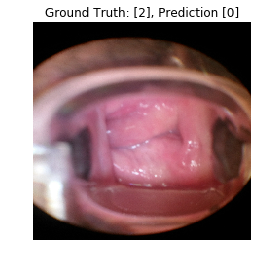

In [118]:
#EVALUATE TRAINED MODEL
import numpy as np
import tensorflow as tf
from nets import inception

slim = tf.contrib.slim

image_size = inception.inception_v1.default_image_size
batch_size = 1

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cervix.get_split('train', cervix_data_dir)
#     images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size, is_training=False)
    images, images_raw, labels = load_batch(dataset, batch_size=32, shuffle=False, height=image_size, width=image_size, is_training=True)
    
    labels = tf.subtract(labels, 1)
    
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=False)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
#             np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
            np_probabilities, np_images_raw, np_labels, np_images, logit_train, one_hot = sess.run([probabilities, images_raw, labels, images, logits, one_hot_labels])
    
            for i in xrange(batch_size): 
                image = np_images_raw[i, :, :, :]
                image_train = np_images[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                print one_hot
                print logit_train
                print np_probabilities
                print np.argmax(np_probabilities, axis=1)
                print np_labels
                
#                 predicted_name = dataset.labels_to_names[predicted_label]
#                 true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
#                 plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_label, predicted_label))
                plt.axis('off')
                plt.show()

In [ ]:
logit_train2 = logit_train

In [ ]:
print image_train.shape
image
f, (ax1, ax2, ax3) = plt.subplots(1, 3,sharey=True)
ax1.imshow(image_train[:,:,0], cmap='gray')
ax2.imshow(image_train[:,:,1], cmap='gray')
ax3.imshow(image_train[:,:,2], cmap='gray')
plt.show()

In [ ]:
#Evaluate metrics
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cervix.get_split('train', cervix_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits) # 32 x 5
    probabilities = tf.argmax(logits,1)
    
    
        # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(probabilities, labels),
#         'eval/Recall@5': slim.metrics.streaming_recall_at_k(logits, labels, 2),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=names_to_updates.values(),
        final_op=names_to_values.values())

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))
        
    tlabels, tpred = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        final_op=[labels, probabilities])
    print tlabels
    print tpred

In [128]:
#CHECK WEIGHTS
import numpy as np
import tensorflow as tf
from nets import inception

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
#     dataset = cervix.get_split('train', cervix_data_dir)
    images, images_raw, labels = load_batch(dataset, shuffle=True, height=image_size, width=image_size, is_training=True)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=False)

    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
#             in_logits = slim.get_variables_by_name('InceptionV1/Logits/Conv2d_0c_1x1/weights')
#             stay_same = slim.get_variables_by_name('InceptionV1/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights')
            variables = slim.get_variables()
#             l_out, ss = sess.run([in_logits, stay_same])
            all_var = sess.run(variables)
        
        print "DONE"

Instructions for updating:
Use `tf.local_variables_initializer` instead.
DONE


In [87]:
np.array(all_var[2]).shape

(64,)

In [64]:
print l_outa.shape
l_outa = np.array(l_out)
l_outa[:,:,:,0:10,:].shape
ssa = np.array(ss)
print ssa.shape
print l_outa[:,:,:,0:10,:]
print ssa[:,:,:,0,:]
# for i in variables:
#     print i.name

(1, 1, 1, 1024, 3)
(1, 1, 1, 832, 128)
[[[[[ 0.0225546  -0.03773157 -0.03563033]
    [ 0.00560903  0.0386457   0.03008164]
    [-0.00972843  0.05667179 -0.03700553]
    [ 0.0324546  -0.0141386   0.02045678]
    [ 0.06317345  0.0256234   0.02454718]
    [ 0.0775746   0.03653196  0.03690426]
    [-0.02463171  0.05951761 -0.04160601]
    [ 0.03234899 -0.00583618 -0.0186235 ]
    [-0.07580843 -0.03416779 -0.01580554]
    [-0.00908197  0.07602486  0.0020398 ]]]]]
[[[[-0.03159119 -0.03172385  0.10651094  0.08326013  0.02682466  0.02241646
    -0.06258097  0.02906412 -0.00209496 -0.10497356  0.02025996 -0.08106352
    -0.01673872 -0.01791217 -0.04079831 -0.05992773 -0.0578336  -0.0627177
    -0.0681162   0.00444865  0.07075203  0.01951352 -0.00307408  0.0244806
     0.03536874  0.03084046  0.0278339   0.02593502  0.01365609 -0.05791332
    -0.03000265  0.07679283  0.06262504 -0.05136951 -0.05276458 -0.00673586
    -0.09805413  0.08242258  0.08185671  0.08718041 -0.05881884 -0.00320945
    -0.

In [66]:
print l_outa.shape
l_outa = np.array(l_out)
l_outa[:,:,:,0:10,:].shape
ssa = np.array(ss)
print ssa.shape
print l_outa[:,:,:,0:10,:]
print ssa[:,:,:,0,:]

(1, 1, 1, 1024, 3)
(1, 1, 1, 832, 128)
[[[[[ 0.0225546  -0.03773157 -0.03563033]
    [ 0.00560903  0.0386457   0.03008164]
    [-0.00972843  0.05667179 -0.03700553]
    [ 0.0324546  -0.0141386   0.02045678]
    [ 0.06317345  0.0256234   0.02454718]
    [ 0.0775746   0.03653196  0.03690426]
    [-0.02463171  0.05951761 -0.04160601]
    [ 0.03234899 -0.00583618 -0.0186235 ]
    [-0.07580843 -0.03416779 -0.01580554]
    [-0.00908197  0.07602486  0.0020398 ]]]]]
[[[[-0.03159119 -0.03172385  0.10651094  0.08326013  0.02682466  0.02241646
    -0.06258097  0.02906412 -0.00209496 -0.10497356  0.02025996 -0.08106352
    -0.01673872 -0.01791217 -0.04079831 -0.05992773 -0.0578336  -0.0627177
    -0.0681162   0.00444865  0.07075203  0.01951352 -0.00307408  0.0244806
     0.03536874  0.03084046  0.0278339   0.02593502  0.01365609 -0.05791332
    -0.03000265  0.07679283  0.06262504 -0.05136951 -0.05276458 -0.00673586
    -0.09805413  0.08242258  0.08185671  0.08718041 -0.05881884 -0.00320945
    -0.

In [ ]:
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
#     dataset = flowers.get_split('train', flowers_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
#     images, labels = image_processing.inputs(c)
#     image = tf.divide(image, 2)
#     image = tf.add(image, 0.5)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=c.num_classes(), is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    
    
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images, labels])
    
#             for i in xrange(FLAGS.batch_size): 
            for i in xrange(3):
                image = np_images_raw[i, :, :, :]
                print images.shape
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                true_name = true_label
                predicted_name = predicted_label
#                 predicted_name = c.labels_to_names[predicted_label]
#                 true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                print image
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()

In [129]:
tensor_to_weights = {}
for i in xrange(len(variables)):
    tensor_to_weights[variables[i].name] = np.array(all_var[i])
i = 0
for key, val in tensor_to_weights.iteritems():
    print "%d %-20.20s mean: %10.10s var: %s" % (i, key, np.mean(val), np.var(val))
    i+=1

0 InceptionV1/Mixed_5b mean: 0.00447396 var: 0.00540011
1 InceptionV1/Mixed_4b mean: -0.0688625 var: 0.915603
2 InceptionV1/Mixed_3b mean:   0.246031 var: 1.70687
3 InceptionV1/Mixed_4d mean: -0.0035932 var: 0.00496677
4 InceptionV1/Logits/C mean: -0.0058033 var: 0.000309601
5 InceptionV1/Mixed_4e mean:  -0.499574 var: 0.140774
6 InceptionV1/Mixed_3b mean: -0.0037440 var: 0.0113337
7 InceptionV1/Mixed_4f mean: -0.0053522 var: 0.00537661
8 InceptionV1/Mixed_4e mean:   0.600758 var: 0.0235995
9 InceptionV1/Mixed_3b mean:  -0.307629 var: 1.0731
10 InceptionV1/Mixed_4e mean:    1.41965 var: 0.166081
11 InceptionV1/Mixed_5c mean:  -0.856011 var: 0.0539253
12 InceptionV1/Mixed_4b mean:    1.20013 var: 0.218713
13 InceptionV1/Mixed_4d mean: -0.0050883 var: 0.00590622
14 InceptionV1/Mixed_4d mean: 0.00028458 var: 0.00552685
15 InceptionV1/Mixed_5c mean:   0.621912 var: 0.0360627
16 InceptionV1/Mixed_4c mean:   0.778888 var: 0.0644302
17 InceptionV1/Mixed_4c mean:    1.18305 var: 0.138806
18 In

In [122]:
tensor_to_weights = {}
for i in xrange(len(variables)):
    tensor_to_weights[variables[i].name] = np.array(all_var[i])
i = 0
for key, val in tensor_to_weights.iteritems():
    print "%d %-20.20s mean: %10.10s var: %s" % (i, key, np.mean(val), np.var(val))
    i+=1

0 InceptionV1/Mixed_5b mean: 0.00446403 var: 0.00537762
1 InceptionV1/Mixed_4b mean: -0.0688452 var: 0.915561
2 InceptionV1/Mixed_3b mean:   0.246011 var: 1.7073
3 InceptionV1/Mixed_4d mean:  -0.003589 var: 0.004943
4 InceptionV1/Logits/C mean: -0.0054134 var: 0.000260293
5 InceptionV1/Mixed_4e mean:  -0.499579 var: 0.140811
6 InceptionV1/Mixed_3b mean: -0.0037834 var: 0.0113062
7 InceptionV1/Mixed_4f mean: -0.0053547 var: 0.00535483
8 InceptionV1/Mixed_4e mean:   0.599648 var: 0.0236065
9 InceptionV1/Mixed_3b mean:  -0.307594 var: 1.07308
10 InceptionV1/Mixed_4e mean:    1.41678 var: 0.16594
11 InceptionV1/Mixed_5c mean:  -0.856184 var: 0.0539572
12 InceptionV1/Mixed_4b mean:    1.19946 var: 0.218637
13 InceptionV1/Mixed_4d mean: -0.0050898 var: 0.00588252
14 InceptionV1/Mixed_4d mean: 0.00027208 var: 0.00550079
15 InceptionV1/Mixed_5c mean:    0.61341 var: 0.0350273
16 InceptionV1/Mixed_4c mean:   0.775499 var: 0.0640959
17 InceptionV1/Mixed_4c mean:    1.18071 var: 0.138585
18 Incep